In [1]:
from CustomEfficientNet import CustomEfficientNet
import lightning.pytorch as pl
from tqdm.auto import tqdm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('high')

In [87]:
model = CustomEfficientNet.load_from_checkpoint("../checkpoints/efficient_net_scratch-v15.ckpt")
model.eval()
model.freeze()

C:\Users\dllni\miniconda3\envs\xai\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [3]:
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os

data_dir = "../New Plant Diseases Dataset(Augmented)"
valid_dir = os.path.join(data_dir, "valid")
batch_size = 32
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())
valid_dl = DataLoader(valid, batch_size, num_workers=4, pin_memory=True, persistent_workers=True)
test_dir = os.path.join(data_dir, "test")
test = ImageFolder(test_dir, transform=transforms.ToTensor())
for k in test.class_to_idx:
    test.class_to_idx[k] = valid.class_to_idx[k]
test.samples = test.make_dataset(test_dir, test.class_to_idx,
                                 extensions=(
                                     ".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp"))
test_dl = DataLoader(test, batch_size, num_workers=4, pin_memory=True, persistent_workers=True)

In [33]:
miss_classified_images = []
from torchmetrics import Accuracy

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
acc = Accuracy("multiclass", num_classes=len(valid.classes)).to(device)

with torch.no_grad():
    for image_lbl in tqdm(valid_dl):
        image, label = image_lbl
        image, label = image.to(device), label.to(device)
        probs = model(image)
        acc.update(probs, label)
        classes = torch.argmax(probs, dim=1)
        idx_differ = torch.where(classes == label, 0, 1).nonzero()
        for i in idx_differ:
            i = int(i)
            miss_classified_images.append({"img": image[i], "prediction": int(classes[i]), "label": int(label[i])})
        if len(miss_classified_images) > 0:
            break

acc.compute()

  0%|          | 0/550 [00:00<?, ?it/s]

tensor(0.9965, device='cuda:0')

In [5]:
# trainer = pl.Trainer(inference_mode=True)
# trainer.test(model, test_dl)

In [6]:
import sys

sys.path.insert(0, "XAI_course_2024")

## Intgrad

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


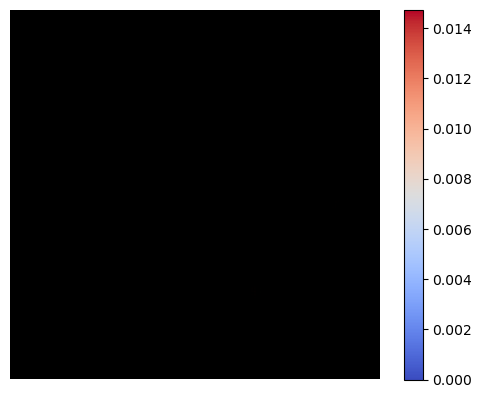

In [57]:
from XAI_course_2024.xailib.explainers.intgrad_explainer import IntgradImageExplainer

model = model.to("cpu")
# 1) Create the Explainer
ig = IntgradImageExplainer(model)

# 2) Fit the Explainer
ig.fit()

# 3) Select the image we want to give an explanation for
wrong_pred = miss_classified_images[0]
image = wrong_pred["img"].to("cpu")


#MNIST_x_data_train[80:81]


# 4a) Preprocessing function: function that takes as input an image and return the correct format for the black box
def preprocessing(image):
    return torch.from_numpy(image).float() if not isinstance(image, torch.Tensor) else image


# 4b) Predict Function of our black box: It needs to take as input the output of preprocessing and return an array of probabilities of classes with shape (-1,num_classes)
def predict(image):
    return torch.nn.functional.softmax(model(image.unsqueeze(dim=0)), dim=1)
    #return MNIST_CNN(image.unsqueeze(0))


# 5) Explain an Instance
intgrad_pt_score = ig.explain(image, wrong_pred["prediction"], 'half', preprocessing=preprocessing, predict=predict,
                              model_type='pytorch', cuda=False)

plt.imshow(intgrad_pt_score, cmap='coolwarm')
plt.colorbar()
plt.axis('off');

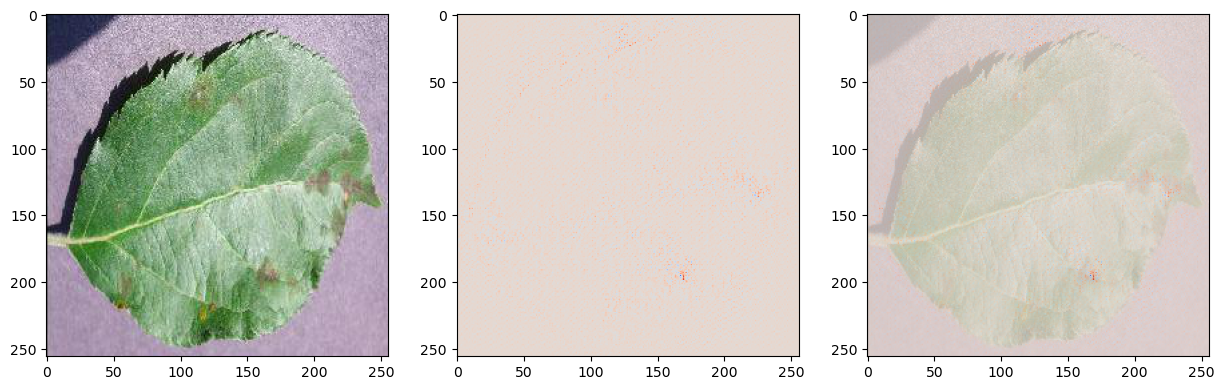

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
np_image = image.numpy() if not isinstance(image, np.ndarray) else image

ax[0].imshow(preprocessing(np_image).permute(1, 2, 0).numpy())
ax[1].imshow(np.sum(intgrad_pt_score, axis=-1), cmap='coolwarm')
ax[2].imshow(preprocessing(np_image).permute(1, 2, 0).numpy(), alpha=1)
ax[2].imshow(np.sum(intgrad_pt_score, axis=-1), cmap='coolwarm', alpha=0.8);

## LIME

In [68]:
from XAI_course_2024.xailib.explainers.lime_explainer import LimeXAIImageExplainer
from skimage.color import label2rgb, gray2rgb, rgb2gray

# 1) Create the Explainer
model = model.to(device)
lm = LimeXAIImageExplainer(model)

# 2a) Fit the Explainer
lm.fit()


# 2b) Create custom classifier function if not predict
# function that takes as input an array of images (the LIME neighbourhood) and return an array of (num_images, num_classes)
# If None will use black_box.predict function
def classifier_fn(images):
    with torch.no_grad():
        #images = torch.tensor(images/255).permute(0,3,1,2).float()
        images = torch.from_numpy(images).permute(0, 3, 1, 2).float()
        pred = torch.nn.functional.softmax(model(images.to(device)), dim=1).cpu().detach().numpy()
        return pred


  0%|          | 0/2000 [00:00<?, ?it/s]

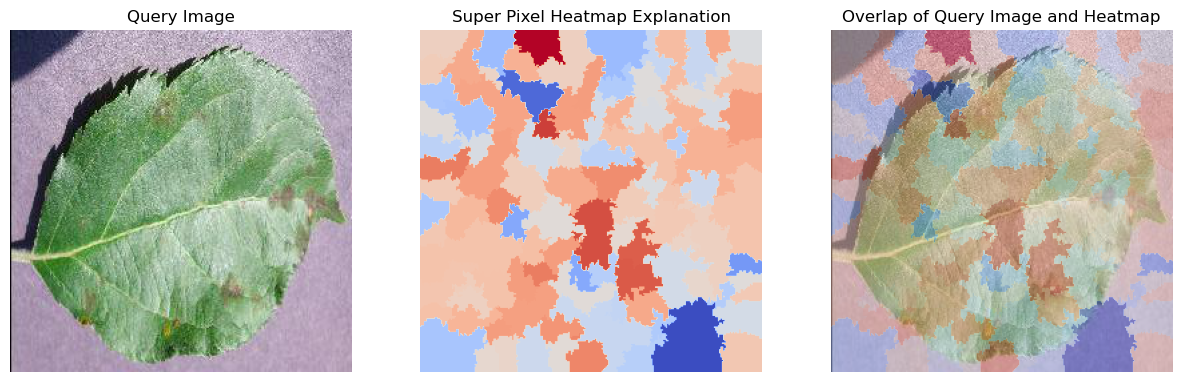

In [69]:
# 3) Explain an Instance
explanation = lm.explain((preprocessing(np_image).permute(1, 2, 0).numpy() * 255).astype(int), classifier_fn,
                         num_samples=1000)

# 4) Plot the results
lm.plot_lime_values(preprocessing(np_image).permute(1, 2, 0).numpy(), explanation)
lime_score = explanation.heatmap

## RISE

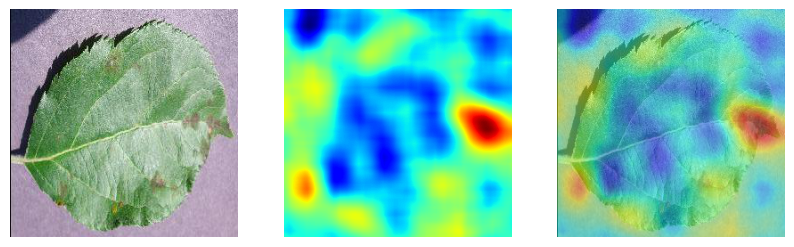

In [91]:
from XAI_course_2024.xailib.explainers.rise_explainer import RiseXAIImageExplainer


class Rise_model_wrapper():
    def __init__(self, bb, input_size):
        self.model = bb
        self.input_size = input_size

    def predict(self, X):
        with torch.no_grad():
            images = torch.tensor(X).permute(0, 3, 1, 2).float()
            return torch.nn.functional.softmax(model(images.to(device)), dim=1).cpu().detach().numpy()


model = model.to(device)
rise_model = Rise_model_wrapper(model, (np_image.shape[1], np_image.shape[1]))
rise = RiseXAIImageExplainer(rise_model)

N = 1000  # number of random masks
s = 10  # cell_size = input_shape / s
p1 = 0.5  # masking probability
pred = wrong_pred['prediction']

rise.fit(N, s, p1)

sal = rise.explain(preprocessing(np_image).permute(1, 2, 0).cpu().detach().numpy())
rise_score = sal[pred, :]

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(preprocessing(np_image).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
ax[0].axis('off')

ax[1].imshow(sal[pred, :], cmap='jet')
ax[1].axis('off')

ax[2].imshow(preprocessing(np_image).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
ax[2].imshow(sal[pred, :], cmap='jet', alpha=0.5)
ax[2].axis('off');

## GradCAM

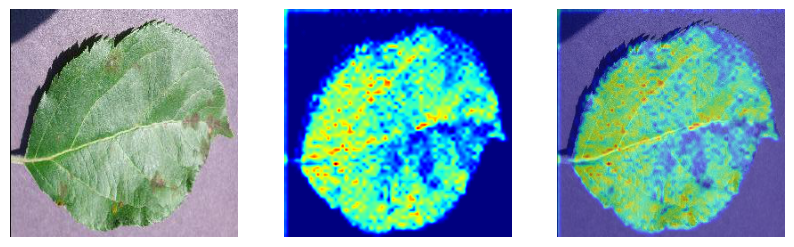

In [131]:
from XAI_course_2024.xailib.explainers.gradcam_explainer import GradCAMImageExplainer

model = CustomEfficientNet.load_from_checkpoint("../checkpoints/efficient_net_scratch-v15.ckpt")
model = model.to(device)

explainer = GradCAMImageExplainer(model)

explainer.fit([model.model.features[2][0].block[1][0]])  #-5,36

attr = explainer.explain(preprocessing(np_image).to(device).unsqueeze(0), pred, model_type='pytorch')
gradcam_pt_score = attr[0, :]

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(preprocessing(np_image).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr[0, :], cmap='jet')
ax[1].axis('off')

ax[2].imshow(preprocessing(np_image).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
ax[2].imshow(attr[0, :], cmap='jet', alpha=0.5)
ax[2].axis('off');

## GradCAM plus

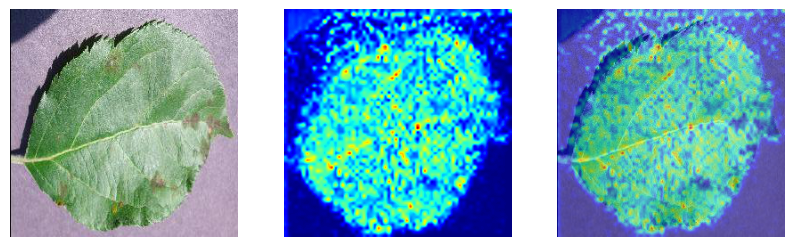

In [132]:
from XAI_course_2024.xailib.explainers.gradcam_explainer import GradCAMPlusPlusImageExplainer

explainer = GradCAMPlusPlusImageExplainer(model)

explainer.fit([model.model.features[2][0].block[1][0]])

attr = explainer.explain(preprocessing(image).to(device).unsqueeze(0), pred, model_type='pytorch')
gradcampp_pt_score = attr[0,:]

fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(preprocessing(image).permute(1,2,0).cpu().detach().numpy(),cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr[0,:],cmap='jet')
ax[1].axis('off')

ax[2].imshow(preprocessing(image).permute(1,2,0).cpu().detach().numpy(),cmap='gray')
ax[2].imshow(attr[0,:],cmap='jet',alpha=0.5)
ax[2].axis('off');

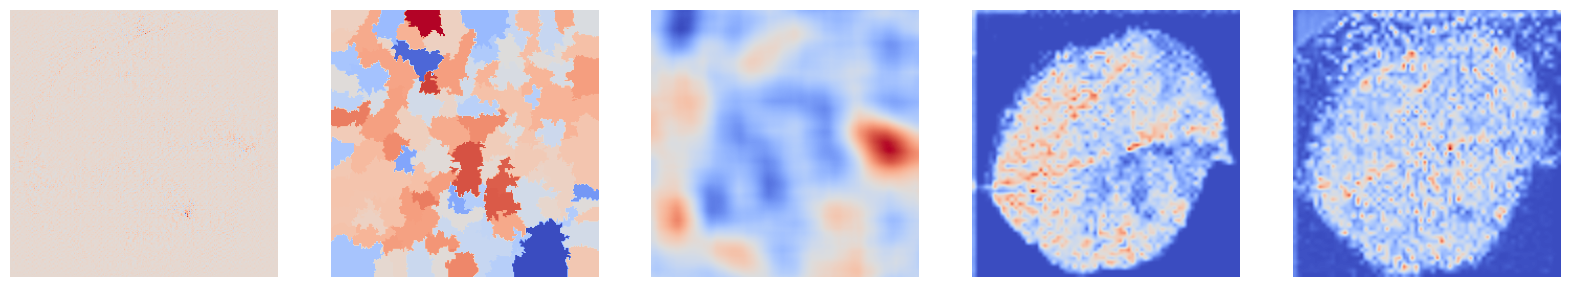

In [133]:
methods = [np.sum(intgrad_pt_score,axis=-1),lime_score,rise_score,gradcam_pt_score,gradcampp_pt_score]
F, ax = plt.subplots(1,5,figsize=(20,5))
for i in range(5):
    ax[i].axis(False)
    ax[i].imshow(methods[i],cmap='coolwarm')

# XAI analysis

In [166]:
from XAI_course_2024.xailib.metrics.insertiondeletion import ImageInsDel

def predict(image):
    with torch.no_grad():
        pred = torch.nn.functional.softmax(model.forward(torch.tensor(image).to(device)),dim=1)
        return pred

step = 256
mode = 'del'
metric = ImageInsDel(predict, mode, step, torch.zeros_like)

C:\Users\dllni\PycharmProjects\XAI Dataset4\Notebooks\XAI_course_2024\xailib\metrics\insertiondeletion.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(self.predict(start.numpy()))


Score: 0.012940419328515418


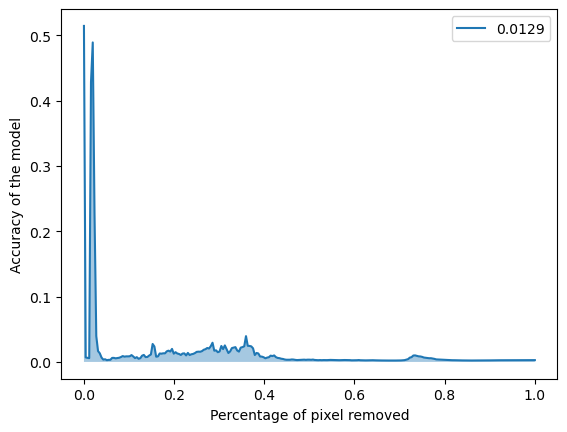

In [167]:
from sklearn.metrics import auc
y = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, intgrad_pt_score, rgb=True)

x = np.arange(len(y))/(step*step)*step
x[-1] = 1.0
print('Score:', auc(x, y))

plt.plot(x, y, label=np.round(auc(x, y),4))
plt.fill_between(x, y, alpha=0.4)
plt.xlabel('Percentage of pixel removed')
plt.ylabel('Accuracy of the model')
plt.legend();

C:\Users\dllni\PycharmProjects\XAI Dataset4\Notebooks\XAI_course_2024\xailib\metrics\insertiondeletion.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(self.predict(img))
C:\Users\dllni\PycharmProjects\XAI Dataset4\Notebooks\XAI_course_2024\xailib\metrics\insertiondeletion.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(self.predict(start.numpy()))


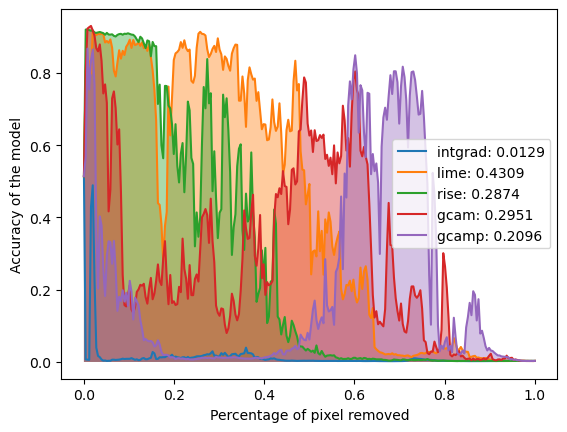

In [169]:
from sklearn.metrics import auc

y_int = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, intgrad_pt_score, rgb=True)
y_rise = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, rise_score, rgb=True)
y_lime = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, lime_score, rgb=True)
y_gcam = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, gradcam_pt_score, rgb=True)
y_gcamp = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, gradcampp_pt_score, rgb=True)
x = np.arange(len(y_int))/(step*step)*step
x[-1] = 1.0

for name, y in zip(['intgrad','lime','rise','gcam','gcamp'],[y_int,y_lime,y_rise,y_gcam,y_gcamp]):
    plt.plot(x, y, label=f'{name}: {np.round(auc(x, y),4)}')
    plt.fill_between(x, y, alpha=0.4)
plt.xlabel('Percentage of pixel removed')
plt.ylabel('Accuracy of the model')
plt.legend();

In [171]:
from sklearn.metrics import auc
[y, anim] = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, rise_score, rgb=True, verbose=1)

In [172]:
anim

C:\Users\dllni\PycharmProjects\XAI Dataset4\Notebooks\XAI_course_2024\xailib\metrics\insertiondeletion.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(self.predict(start.numpy()))
Exception ignored in: <function BaseCAM.__del__ at 0x000002556AC2DB40>
Traceback (most recent call last):
  File "C:\Users\dllni\PycharmProjects\XAI Dataset4\Notebooks\XAI_course_2024\xailib\explainers\gradcam_explainer.py", line 293, in __del__
  File "C:\Users\dllni\PycharmProjects\XAI Dataset4\Notebooks\XAI_course_2024\xailib\explainers\gradcam_explainer.py", line 107, in release
KeyboardInterrupt: 


KeyboardInterrupt: 

C:\Users\dllni\AppData\Local\Temp\ipykernel_101276\1762245224.py:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
C:\Users\dllni\AppData\Local\Temp\ipykernel_101276\1762245224.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).float()


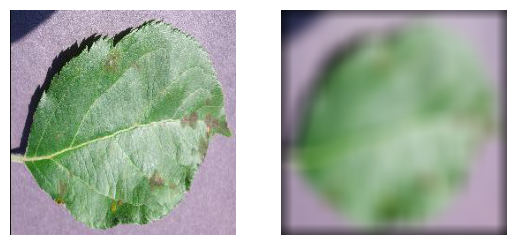

In [173]:
import torch.nn as nn
from scipy.ndimage.filters import gaussian_filter
CH = 3
def gkern(klen, nsig):
    """Returns a Gaussian kernel array.
    Convolution with it results in image blurring."""
    # create nxn zeros
    inp = np.zeros((klen, klen))
    # set element at the middle to one, a dirac delta
    inp[klen//2, klen//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    k = gaussian_filter(inp, nsig)
    kern = np.zeros((CH, CH, klen, klen))
    for i in range(CH):
        kern[i, i] = k
    return torch.from_numpy(kern.astype('float32'))

# Function that blurs input image
def blur(image, klen=25, ksig=25):
    kern = gkern(klen, ksig)
    image = torch.tensor(image).float()
    return nn.functional.conv2d(image, kern, padding=klen//2)

F,ax = plt.subplots(1,2)
ax[0].imshow(preprocessing(np_image).permute(1,2,0).numpy(), cmap='gray')
ax[0].axis(False)
ax[1].imshow(blur(preprocessing(np_image)).permute(1,2,0),cmap='gray')
ax[1].axis(False);

In [174]:
from XAI_course_2024.xailib.metrics.insertiondeletion import ImageInsDel

def predict(image):
    with torch.no_grad():
        pred = torch.nn.functional.softmax(model.forward(torch.tensor(image).to(device)),dim=1)
        return pred

step = 256
mode = 'ins'
metric = ImageInsDel(predict, mode, step, blur)

C:\Users\dllni\AppData\Local\Temp\ipykernel_101276\1762245224.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).float()
C:\Users\dllni\PycharmProjects\XAI Dataset4\Notebooks\XAI_course_2024\xailib\metrics\insertiondeletion.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(self.predict(start.numpy()))


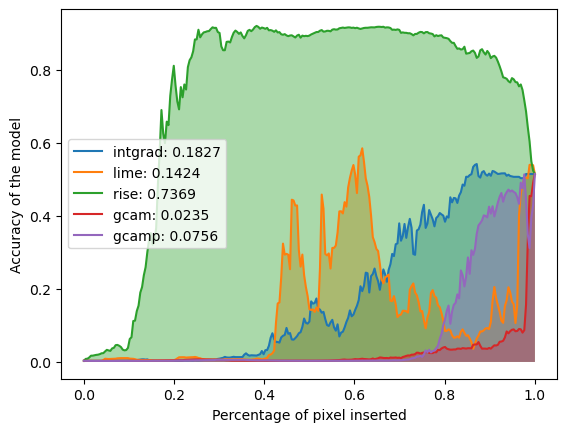

In [177]:
from sklearn.metrics import auc

y_int = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, intgrad_pt_score, rgb=True)
y_rise = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, rise_score, rgb=True)
y_lime = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, lime_score, rgb=True)
y_gcam = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, gradcam_pt_score, rgb=True)
y_gcamp = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, gradcampp_pt_score, rgb=True)
x = np.arange(len(y_int))/(256*256)*step
x[-1] = 1.0

for name, y in zip(['intgrad','lime','rise','gcam','gcamp'],[y_int,y_lime,y_rise,y_gcam,y_gcamp]):
    plt.plot(x, y, label=f'{name}: {np.round(auc(x, y),4)}')
    plt.fill_between(x, y, alpha=0.4)
plt.xlabel('Percentage of pixel inserted')
plt.ylabel('Accuracy of the model')
plt.legend();